In [14]:
import matplotlib

matplotlib.use("Agg")

import argparse
import os
import random
import cv2

import matplotlib.pyplot as plt
import numpy as np
from keras.models import model_from_json
from skimage import exposure, io, transform
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# import the necessary packages
from trafficsignnet import TrafficSignNet

In [15]:
def load_split(basePath, csvPath):
	# initialize the list of data and labels
	data = []
	labels = []

	# load the contents of the CSV file, remove the first line (since
	# it contains the CSV header), and shuffle the rows (otherwise
	# all examples of a particular class will be in sequential order)
	rows = open(csvPath).read().strip().split("\n")[1:]
	random.shuffle(rows)

	# loop over the rows of the CSV file
	for (i, row) in enumerate(rows):
		# check to see if we should show a status update
		if i > 0 and i % 1000 == 0:
			print("[INFO] processed {} total images".format(i))

		# split the row into components and then grab the class ID
		# and image path
		(label, imagePath) = row.strip().split(",")[-2:]

		# derive the full path to the image file and load it
		imagePath = os.path.sep.join([basePath, imagePath])
		image = io.imread(imagePath)

		# resize the image to be 32x32 pixels, ignoring aspect ratio,
		# and then perform Contrast Limited Adaptive Histogram
		# Equalization (CLAHE)
		image = transform.resize(image, (28, 28)) 
		image = exposure.equalize_adapthist(image, clip_limit=0.1)
		image = (image * 255).astype('uint8')

		image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

		# update the list of data and labels, respectively
		data.append(image)
		labels.append(int(label))

	# convert the data and labels to NumPy arrays
	data = np.array(data)
	labels = np.array(labels)

	# return a tuple of the data and labels
	return (data, labels)

In [16]:
# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 20
INIT_LR = 1e-3
BS = 64

dataset_path = "./my_gtsrb"

# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

# derive the path to the training and testing CSV files
trainPath = os.path.sep.join([dataset_path, "Train.csv"])
testPath = os.path.sep.join([dataset_path, "Test.csv"])

# load the training and testing data
print("[INFO] loading training and testing data...")
(trainX, trainY) = load_split(dataset_path, trainPath)
(testX, testY) = load_split(dataset_path, testPath)

# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# [INFO] processed 39000 total images
# [INFO] processed 12000 total images

[INFO] loading training and testing data...
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images


In [17]:
print(trainX.shape, testX.shape)
print(trainY.shape, testY.shape)

(11010, 28, 28) (3570, 28, 28)
(11010,) (3570,)


In [18]:


# one-hot encode the training and testing labels
numLabels = len(np.unique(trainY))
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)

In [19]:
# account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

classWeight = {i: classWeight[i] for i in range(len(classWeight))}

In [20]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model = TrafficSignNet.build(width=28, height=28, depth=1,
	classes=numLabels)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


/home/gustavo/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
trainX = np.expand_dims(trainX, axis=-1)  # Adding channel dimension to training data
testX = np.expand_dims(testX, axis=-1) 

print(trainX.shape)

(11010, 28, 28, 1)


In [22]:
print("[INFO] training network...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BS,
	epochs=NUM_EPOCHS,
	class_weight=classWeight,
	verbose=1)

[INFO] training network...
Epoch 1/20
172/172 [==============================] - 7s 34ms/step - loss: 5.7791 - accuracy: 0.2165 - val_loss: 2.7705 - val_accuracy: 0.1188
Epoch 2/20
172/172 [==============================] - 5s 30ms/step - loss: 3.6655 - accuracy: 0.4421 - val_loss: 2.5337 - val_accuracy: 0.2213
Epoch 3/20
172/172 [==============================] - 5s 27ms/step - loss: 2.7634 - accuracy: 0.5951 - val_loss: 0.8590 - val_accuracy: 0.7106
Epoch 4/20
172/172 [==============================] - 6s 34ms/step - loss: 2.3267 - accuracy: 0.6677 - val_loss: 0.7768 - val_accuracy: 0.7207
Epoch 5/20
172/172 [==============================] - 5s 29ms/step - loss: 2.0572 - accuracy: 0.7180 - val_loss: 0.9561 - val_accuracy: 0.6874
Epoch 6/20
172/172 [==============================] - 5s 30ms/step - loss: 1.7395 - accuracy: 0.7583 - val_loss: 0.6147 - val_accuracy: 0.7927
Epoch 7/20
172/172 [==============================] - 5s 27ms/step - loss: 1.7162 - accuracy: 0.7633 - val_loss: 0.

[INFO] evaluating network...
56/56 [==============================] - 0s 5ms/step
                       precision    recall  f1-score   support

 Speed limit (30km/h)       0.90      0.99      0.95       720
                 Stop       0.93      0.94      0.94       270
             No entry       1.00      0.92      0.96       360
            Road work       0.94      0.96      0.95       480
          Pedestrians       0.78      0.48      0.60        60
    Children crossing       0.92      0.89      0.90       150
    Bicycles crossing       0.59      0.84      0.70        90
Wild animals crossing       0.97      0.95      0.96       270
           Ahead only       0.99      0.95      0.97       390
           Keep right       0.95      0.91      0.93       690
            Keep left       1.00      0.91      0.95        90

             accuracy                           0.93      3570
            macro avg       0.91      0.89      0.89      3570
         weighted avg       0.94  

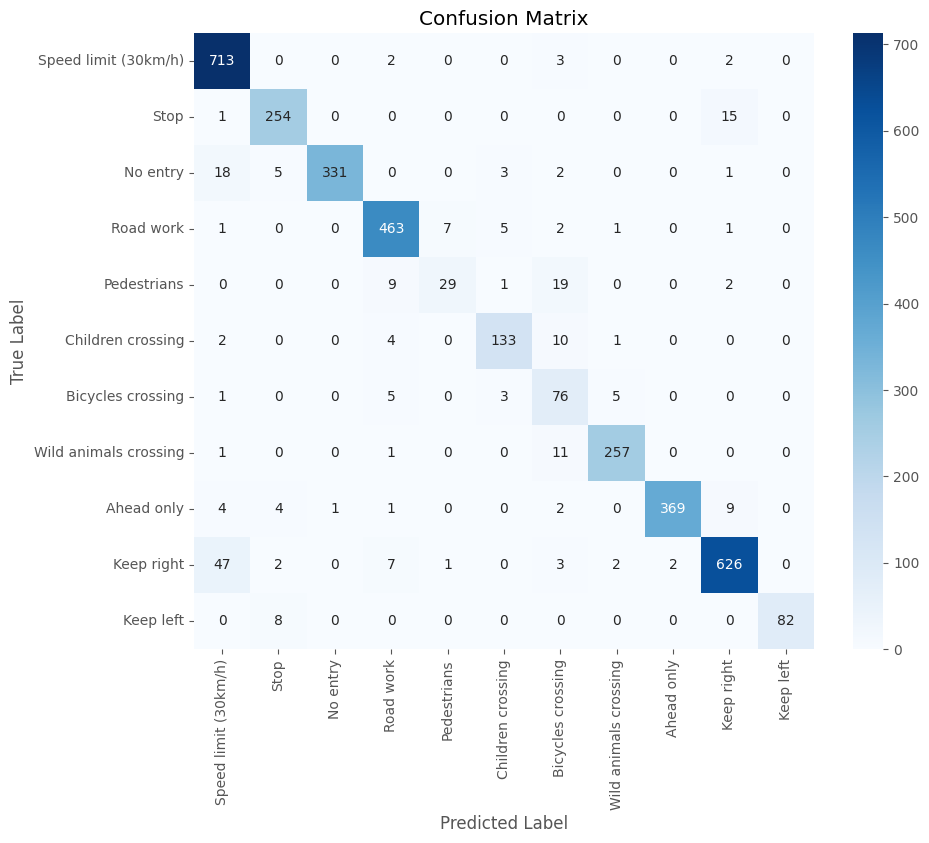

In [23]:
%matplotlib inline

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your model is already trained and test data is prepared

print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)

# Convert predictions and true labels to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(testY, axis=1)

# Generate the classification report
print(classification_report(true_classes, predicted_classes, target_names=labelNames))

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labelNames, yticklabels=labelNames)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [24]:
model_path = 'model/trafficsignnet.model'

# save the network to disk
print("[INFO] serializing network to '{}'...".format(model_path))
model.save(model_path)
model.save_weights('model/model_weights.h5')
model.save('model/saved_model.h5')

model_json = model.to_json()
with open("model/model.json", "w") as json_file:
            json_file.write(model_json)

[INFO] serializing network to 'model/trafficsignnet.model'...


INFO:tensorflow:Assets written to: model/trafficsignnet.model/assets


INFO:tensorflow:Assets written to: model/trafficsignnet.model/assets


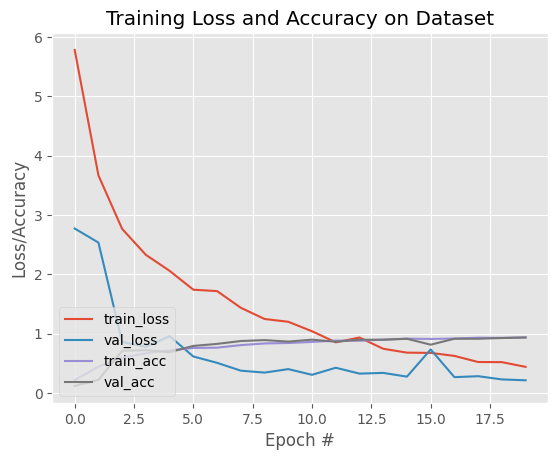

In [25]:


# plot the training loss and accuracy
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("output/plot.png")

In [26]:
import tensorflow as tf

model = tf.keras.models.load_model('./model/trafficsignnet.model')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("./model/trafficsignnet.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpy2y__zgb/assets


INFO:tensorflow:Assets written to: /tmp/tmpy2y__zgb/assets
2024-06-24 18:11:55.385553: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-06-24 18:11:55.385590: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-06-24 18:11:55.385773: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpy2y__zgb
2024-06-24 18:11:55.391316: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-06-24 18:11:55.391346: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpy2y__zgb
2024-06-24 18:11:55.411057: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-06-24 18:11:55.503575: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpy2y__zgb
2024-06-24 18:11:55.535487: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

301772